In [1]:
import matplotlib.pyplot as plt
import numpy as np

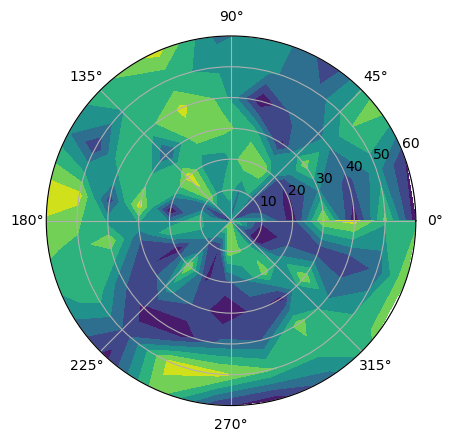

In [2]:
#-- Generate Data -----------------------------------------
# Using linspace so that the endpoint of 360 is included...
azimuths = np.radians(np.linspace(0, 360, 20))
zeniths = np.arange(0, 70, 10)

r, theta = np.meshgrid(zeniths, azimuths)
values = np.random.random((azimuths.size, zeniths.size))

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, values)

plt.show()

In [159]:
import matplotlib.pyplot as plt
import scipy.interpolate
import numpy as np
import PyPDF2
import numpy as np
import os
import re

os.chdir(r'I:\FPA Operations\HgCdTe FPAs\Database\Processing\1 _ Work Center Engineering Notes\PHOTO WORK CENTER\OSIRIS Auto Dispenser and Coater\Ellipsometry Data\Spinner Project\old spinner data\PR Recipe 1\5x5 Silicon')

pdfname = "5x5_Silicon4_CircularScan_NoEdge_Stats.pdf"
all_content = ''
with open(pdfname, "rb") as pdf_file:
    read_pdf = PyPDF2.PdfReader(pdf_file)
    num_pages = len(read_pdf.pages)
    for page_num in np.arange(num_pages):
        page = read_pdf.pages[int(page_num)]
        page_content = page.extract_text()
        all_content += page_content

patt_stddev = r"StdDev\s*(.*?)\s" 
patt_mean = r"Mean\s*(.*?)\s" 
patt_rad = r"R=\s*(.*?),"
patt_theta = r"Theta=\s*(.*?),"
patt_thick = r"Thick1=\s*(.*?),"
stddev = float(re.search(patt_stddev, all_content).group(1))
mean = float(re.search(patt_mean, all_content).group(1))
matches_rad = re.findall(patt_rad, all_content)
matches_theta = re.findall(patt_theta, all_content)
matches_thick = re.findall(patt_thick, all_content)
rad_arr = np.array(matches_rad).astype(float)
theta_arr = np.radians(np.array(matches_theta).astype(float))
thick_arr = np.array(matches_thick).astype(float)

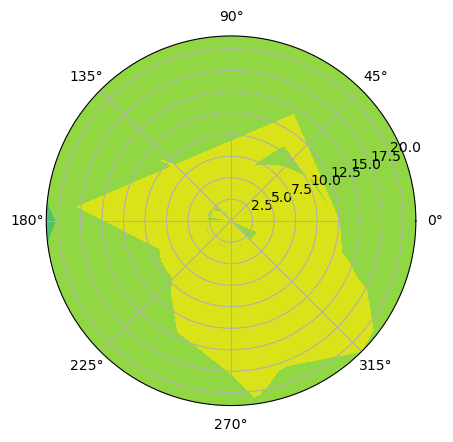

In [116]:
# scipy.interpolate.Rbf is legacy code
# so we will abandon this approach below

r, theta = np.meshgrid(rad_arr, theta_arr)
rbf = scipy.interpolate.Rbf(rad_arr, theta_arr, thick_arr, function='cubic')
thick = rbf(r, theta)

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, thick)

plt.show()

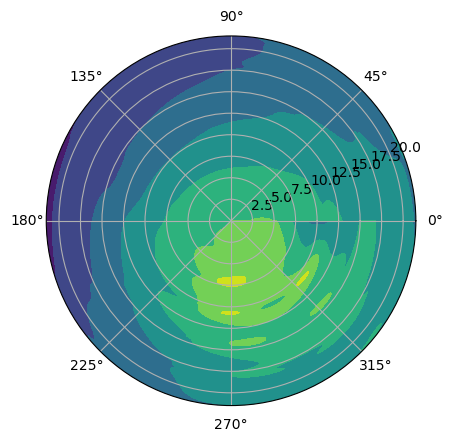

In [121]:
# First attempt using RBFInterpolate.
# This version fails since we create the rbf fit using polar coords.
# The rbf fit assumes cartesian coordinates,
# thus the result is stretched when plotted via polar coords.

pairings = np.stack([theta_arr, rad_arr], axis=-1)
rbf = scipy.interpolate.RBFInterpolator(pairings, thick_arr, kernel='cubic')
r = np.linspace(min(rad_arr), max(rad_arr), 300)
theta = np.linspace(0, 2*np.pi, 300)
theta_grid, r_grid = np.meshgrid(theta, r)
grid_pairs = np.stack([theta_grid.ravel(), r_grid.ravel()], axis=-1)
z_interp_flat = rbf(grid_pairs)
z = z_interp_flat.reshape(r_grid.shape)

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta_grid, r_grid, z)

plt.show()

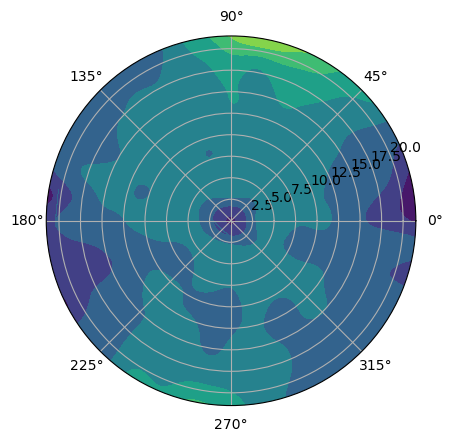

In [160]:
# Second attempt using RBFInterpolate.
# Successful due to converting between polar and cartesian.

# Convert r and theta to cartesian (x and y).
x = rad_arr * np.cos(theta_arr)
y = rad_arr * np.sin(theta_arr)
# Pair each x and y point in a new array.
pairings = np.stack([x, y], axis=-1)

# Create the Radial Basis Function interpolation.
rbf = scipy.interpolate.RBFInterpolator(pairings, thick_arr, kernel='cubic')

# Create a denser meshgrid to plot on.
x_dense = np.linspace(min(x), max(x), 800)
y_dense = np.linspace(min(y), max(y), 800)
x_grid, y_grid = np.meshgrid(x_dense, y_dense)
# Flatten the 2D grid arrays and pair the coordinates.
# This is needed since RBFInterpolate expects a single 2D array.
grid_pairs = np.stack([x_grid.ravel(), y_grid.ravel()], axis=-1)

# Apply the interpolation function to the paired grid points.
z_interp_flat = rbf(grid_pairs)
# Reshape the pairings to the original grid shape.
z = z_interp_flat.reshape(x_grid.shape)

# Convert the x and y grid to a polar grid.
r_grid = np.sqrt(x_grid**2 + y_grid**2)
theta_grid = np.arctan2(y_grid, x_grid)

# Now plot, specifying a polar grid system.
#fig, ax = plt.subplots()
#ax.contourf(x_grid, y_grid, z)
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta_grid, r_grid, z)
ax.set_ylim(0, max(rad_arr))

plt.show()

In [286]:
import matplotlib.pyplot as plt
import scipy.interpolate
import numpy as np
import PyPDF2
import re


class EllipMap:
    """Extracts relevant statistical information from
    the pdf output on the Gaertner 2D Ellipsometer.

    Includes an interpolation function for creating either
    a cartesian or polar meshgrid appropriate for contour plots.

    Attributes:
        stddev (float): The standard deviation of the
            thickness read by the ellipsometer.
        mean (float): The average thickness read
            by the ellipsometer.
        rad_arr (np.ndarray): Array that contains the
            extracted radial coordinates for a
            particular scan/run.
        theta_arr (np.ndarray): Array that contains the
            extracted theta (angular) coordinates for
            a particular scan/run.
        thick_arr (np.ndarray): Array that contains the
            extracted thickness measurements at each
            radial and angular coordinate.
    """

    def __init__(self, pdfpath):
        """Read in pdf file and extract relevant information.

        Information extracted includes the mean, standard deviation,
        radial coordinates, angular coordinates, and
        thickness measurements for each coordinate pair.

        Args:
            pdfpath (str): The directory filepath to the
                pdf of interest.
                
        Returns:
            None.
        """
        all_content = ''  # string to append statistics to
        # Open the pdf file using PyPDF2.
        # Iterate through each page, extract
        # the data as text, and append to a string.
        with open(pdfpath, "rb") as pdf_file:
            read_pdf = PyPDF2.PdfReader(pdf_file)
            num_pages = len(read_pdf.pages)
            for page_num in np.arange(num_pages):
                page = read_pdf.pages[int(page_num)]
                page_content = page.extract_text()
                all_content += page_content

        # Define the regex used to filter the
        # string of all data.
        patt_stddev = r"StdDev\s*(.*?)\s" 
        patt_mean = r"Mean\s*(.*?)\s" 
        patt_rad = r"R=\s*(.*?),"
        patt_theta = r"Theta=\s*(.*?),"
        # Include the possibility of 'No Solution' for thickness.
        patt_thick = r"Thick1=\s*(.*?),|No Soution"

        # Find the mean and standard deviation
        # using the re.search function.
        self.stddev = float(re.search(patt_stddev, all_content).group(1))
        self.mean = float(re.search(patt_mean, all_content).group(1))

        # Now for radial, angular, and thickness data
        # find all the matches from each regex input
        # and place the matches into a list.
        matches_rad = re.findall(patt_rad, all_content)
        matches_theta = re.findall(patt_theta, all_content)
        # Replace instances of 'No Solution' with nan.
        # 'No Solution' is returned as '' from our regex algorithm.
        matches_thick = np.array(re.findall(patt_thick, all_content))
        matches_thick[matches_thick == ''] = np.nan

        # transform list into np.ndarray with floats
        self.rad_arr = np.array(matches_rad).astype(float)
        self.theta_arr = np.radians(np.array(matches_theta).astype(float))

        # We have a bit more work to do for thicknesses.
        # After transforming to floats, identify any nan values
        # and replace them with linearly interpolated values.
        self.thick_arr = np.array(matches_thick).astype(float, casting='unsafe')
        mask = np.isnan(self.thick_arr)
        self.thick_arr[mask] = np.interp(
            np.flatnonzero(mask),
            np.flatnonzero(~mask),
            self.thick_arr[~mask])

    def interp_grid(self, polar_coords, ptnum):
        """Create a meshgrid and interpolate.

        The Radial Basis Function is used to interpolate
        over a fine meshgrid in preparation for data
        manipulation and contour plotting.

        Args:
            polar_coords (bool): If True, the meshgrid
                will be returned as polar coordinates.
                If False, coordinates remain cartesian.
            ptnum (int): The number of points along
                either axis in the meshgrid, resulting
                in a grid of (ptnum * ptnum) total points.

        Returns:
            grid1 (np.ndarray): 2D array of either the
                x or radial coordinates of the meshgrid.
            grid2 (np.ndarray): 2D array of either the
                y or theta coordinates of the meshgrid.
            z (np.ndarray): The z-values associated with
                each coordinate pairing in the meshgrid.
        """
        # Convert r and theta to cartesian (x and y).
        x = self.rad_arr * np.cos(self.theta_arr)
        y = self.rad_arr * np.sin(self.theta_arr)
        # Pair each x and y point in a new array.
        pairings = np.stack([x, y], axis=-1)
        
        # Create the Radial Basis Function interpolation.
        rbf = scipy.interpolate.RBFInterpolator(pairings, self.thick_arr, kernel='cubic')
        
        # Create a denser meshgrid to plot on.
        x_dense = np.linspace(min(x), max(x), ptnum)
        y_dense = np.linspace(min(y), max(y), ptnum)
        x_grid, y_grid = np.meshgrid(x_dense, y_dense)
        # Flatten the 2D grid arrays and pair the coordinates.
        # This is needed since RBFInterpolate expects a single 2D array.
        grid_pairs = np.stack([x_grid.ravel(), y_grid.ravel()], axis=-1)
        
        # Apply the interpolation function to the paired grid points.
        z_interp_flat = rbf(grid_pairs)
        # Reshape the pairings to the original grid shape.
        z = z_interp_flat.reshape(x_grid.shape)

        if polar_coords == True:
            # Convert the x and y grid to a polar grid.
            r_grid = np.sqrt(x_grid**2 + y_grid**2)
            theta_grid = np.arctan2(y_grid, x_grid)
            grid1, grid2 = r_grid, theta_grid
        else:
            # Keep meshgrid in cartesian.
            grid1, grid2 = x_grid, y_grid
            
        return grid1, grid2, z

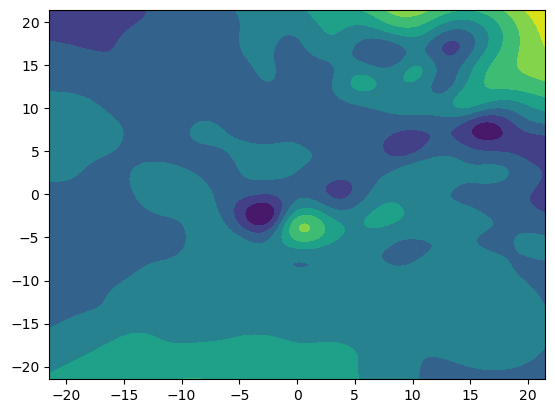

In [15]:
new = EllipMap(r"I:\FPA Operations\HgCdTe FPAs\Database\Processing\1 _ Work Center Engineering Notes\PHOTO WORK CENTER\OSIRIS Auto Dispenser and Coater\Ellipsometry Data\Spinner Project\old spinner data\PR Recipe 1\5x5 Silicon\5x5_Silicon1_CircularScan_NoEdge_Stats.pdf")
x_grid, y_grid, z = new.interp_grid(False, 800)
fig, ax = plt.subplots()
ax.contourf(x_grid, y_grid, z)
plt.show()

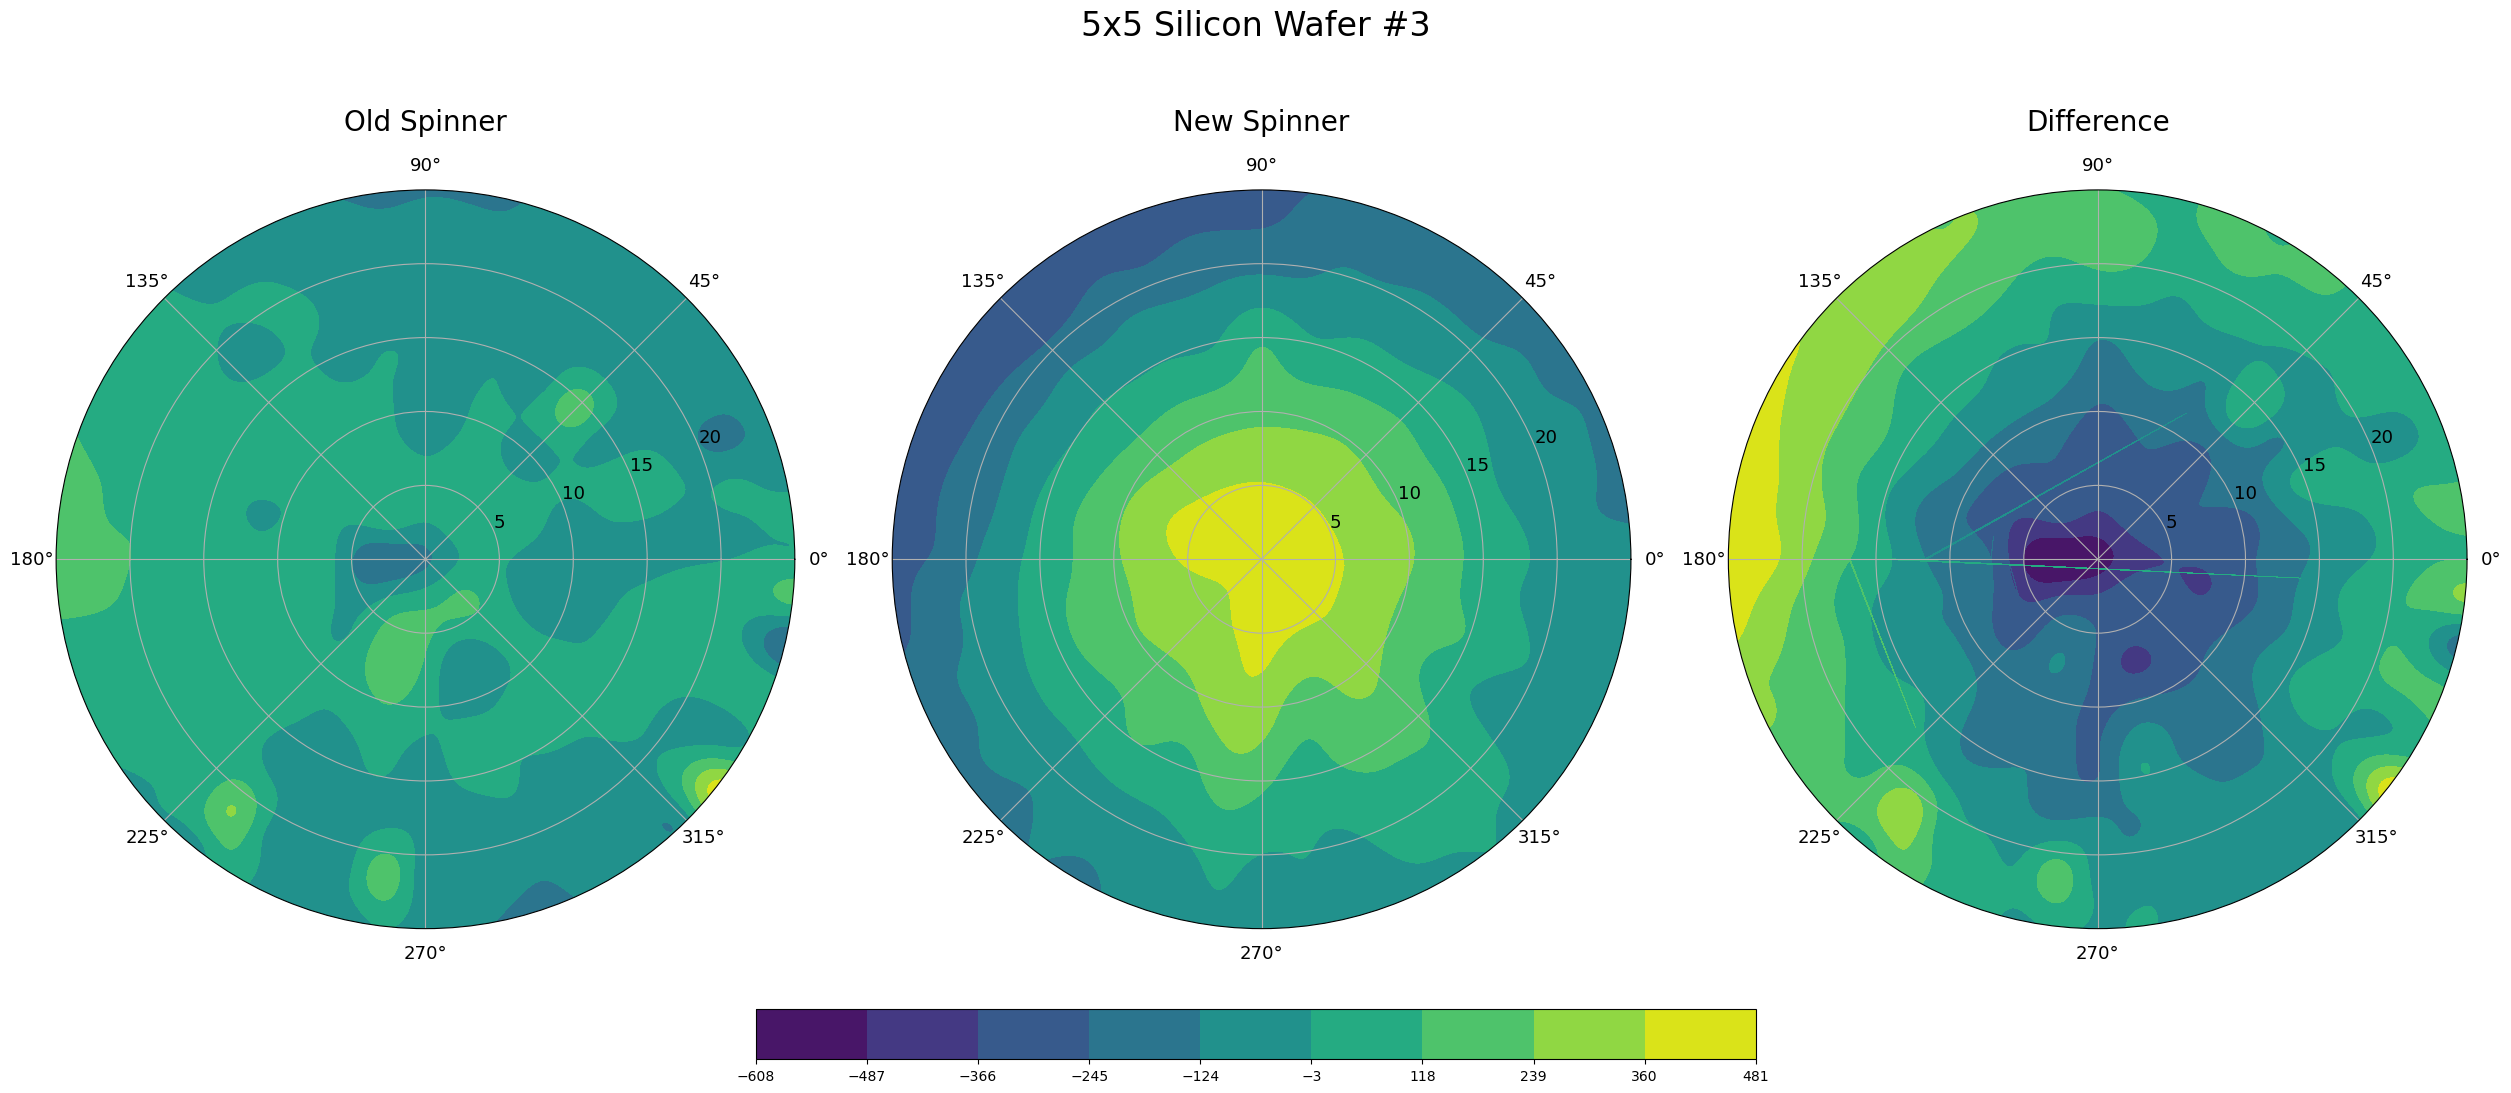

In [294]:
old_spin = EllipMap(r"I:\FPA Operations\HgCdTe FPAs\Database\Processing\1 _ Work Center Engineering Notes\PHOTO WORK CENTER\OSIRIS Auto Dispenser and Coater\Ellipsometry Data\Spinner Project\old spinner data\PR Recipe 1\6x6 Silicon\6x6_Silicon1_CircularScan_NoEdge_Stats.pdf")
r_grid_old, theta_grid_old, z_old = old_spin.interp_grid(True, 800)

new_spin = EllipMap(r"I:\FPA Operations\HgCdTe FPAs\Database\Processing\1 _ Work Center Engineering Notes\PHOTO WORK CENTER\OSIRIS Auto Dispenser and Coater\Ellipsometry Data\Spinner Project\new spinner data\Teledyne + Osiris PR Recipe\6x6 Silicon\6x6_Silicon1_CircularScan_TeledyneOsiris_Data.pdf")
r_grid_new, theta_grid_new, z_new = new_spin.interp_grid(True, 800)

norm_z_old = z_old - old_spin.mean
norm_z_new = z_new - new_spin.mean

diff_z = norm_z_old - norm_z_new

fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), 
                       figsize=(25, 25), constrained_layout=True)
plt.suptitle("5x5 Silicon Wafer #3", size=24, y=0.72)

# Find the maximum and minimum of all data
# and define shared levels for all plots.
exact_levels = np.linspace(np.min((norm_z_old, norm_z_new, diff_z)),
                           np.max((norm_z_old, norm_z_new, diff_z)), 10)

# Plot the normalized old spinner data.
old_plot = ax[0].contourf(theta_grid_old, r_grid_old,
                          norm_z_old, levels=exact_levels)
ax[0].set_ylim(0, max(old_spin.rad_arr))
ax[0].set_title("Old Spinner", y = 1.07, fontsize = 20)
ax[0].tick_params(axis='x', labelsize=13, pad=7)
ax[0].tick_params(axis='y', labelsize=13, pad=7)

# Plot the normalized new spinner data.
new_plot = ax[1].contourf(theta_grid_new, r_grid_new,
                          norm_z_new, levels=exact_levels)
ax[1].set_ylim(0, max(new_spin.rad_arr))
ax[1].set_title("New Spinner", y = 1.07, fontsize = 20)
ax[1].tick_params(axis='x', labelsize=13, pad=7)
ax[1].tick_params(axis='y', labelsize=13, pad=7)

# Plot the normalized difference between old and new spinner data.
diff_plot = ax[2].contourf(theta_grid_old, r_grid_old,
                           diff_z, levels=exact_levels)
ax[2].set_ylim(0, max(old_spin.rad_arr))
ax[2].set_title("Difference", y = 1.07, fontsize = 20)
ax[2].tick_params(axis='x', labelsize=13, pad=7)
ax[2].tick_params(axis='y', labelsize=13, pad=7)

#ax[3].set_axis_off()
#cbar_diff = fig.colorbar(diff_plot, ax=ax[3], shrink=0.25, location='left')
cbar_pos = [0.3, 0.3, 0.4, 0.02]
cax = fig.add_axes(cbar_pos)
# Create the colorbar using the custom axes
cbar = fig.colorbar(diff_plot, cax=cax, orientation='horizontal')

#plt.savefig(r"C:\Users\JChristensen01\Downloads\5x5_Silicon3.png", dpi=250, bbox_inches='tight')